In [1]:
import errno
import os
from pathlib import Path
from datetime import datetime, date, timedelta

import pandas as pd
from ipyfilechooser import FileChooser

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as md
from matplotlib.offsetbox import AnchoredText

Константы с параметрами и заголовками

In [2]:
# Параметры из файлов с данными которые нужны
NEEDED_PARAMETERS = (
    "hmax",
    "FiltWindow",
    "Time Range",
    "Minimum duration of series",
    "time step"
)
# Заголовки колонок данных в текстовом файле
DATA_HEADERS = (
    "tsn", "time", "el", "az",
    "latp", "lonp", "tec",
    "tec_filtered", "validity"
)
# TODO: сделать проще - задание форматом HH:MM
# Временной интервал для отрисовки графика
FLOAT_TIME_START = 18.50  # это значит время 18:30
FLOAT_TIME_END = 21.00
# В формат Pandas
TIME_START = pd.to_datetime(18.50, unit='h')
TIME_END = pd.to_datetime(21.00, unit='h')

In [3]:
def get_date_by_number(year=None, day_number=1):
    """Вычисление даты в заданном году по номеру дня."""
    if year is None or year < 1970 or day_number <= 0:
        raise ValueError("Enter correct year/day number.")
    return date(year, 1, 1) + timedelta(days=day_number-1)

In [4]:
def get_day_number(year=1970, month=1, day=1, dt_format=None):
    """Вычисление номера дня в году по дате."""
    if dt_format:
        return dt_format.timetuple().tm_yday
    return date(year, month, day).timetuple().tm_yday

In [5]:
def parse_filename(filename=""):
    """Парсинг имени файла на: stk2G20_165.dat
       stk2 - имя пункта гнсс (4 символа),
       G20 - тип и номер спутника (3 символа),
       165 - номер дня в году"""
    # TODO: добавить обработку ошибок
    name, _ = os.path.basename(filename).split(".")
    name_part, day_number = name.split("_")
    return {
        "day_number": day_number,
        "receiver_name": name_part[:4],  # TODO: уточнить англ. термин
        "sat_name": name_part[4:7],
    }

In [6]:
def get_params_datafile(filename=""):
    """Функция для сбора параметров из файла .dat
    из строк в начале файла начинающихся с символа #.
    Возвращает словарь.
    """
    if not filename:
        raise ValueError("Filename is needed.")

    if not os.path.isfile(filename):
        raise FileNotFoundError(
            errno.ENOENT,
            os.strerror(errno.ENOENT),
            filename
        )

    params = []

    with open(filename, 'r') as tec_file:
        for line in tec_file.readlines():
            if line.strip().startswith("#"):  # это параметр
                param = line.strip()[1:]
                param = param.split("=")
                if len(param) != 2:  # заголовки пропускаем
                    continue
                param = tuple(el.strip() for el in param)
                params.append(param)
    
    params = dict(params)

    # оставляем только нужные параметры
    return {
        key: params[key]
        for key
        in NEEDED_PARAMETERS
    }

In [7]:
def get_dataframe_datafile(filename=""):
    """Возвращает датафрейм с данными из текстового файла TEC.
    Заголовки задаются в константе."""
    return pd.read_csv(
        filepath_or_buffer=filename,
        delim_whitespace=True,  # разделитель - пробел(ы)
        comment="#",  # пропускаем комменты
        names=DATA_HEADERS, # задание заголовков из списка
    )

In [11]:
def plot_waveform(filename=None):
    """Создание графика и сохранение в файл."""
    name, _ = os.path.basename(filename).split(".")
    plot_filename = ".".join([name, "png"])
    file_name_parts = parse_filename(filename)
    
    anchored_text_label = (
        f"{file_name_parts['day_number']}"
        f" {file_name_parts['receiver_name']}"
        f" {file_name_parts['sat_name']}"
    )
    
    dataframe = get_dataframe_datafile(filename)
    dataframe["time"] = pd.to_datetime(dataframe["time"], unit='h')
    
    dataframe = dataframe[
        (dataframe["time"] >= TIME_START) & (dataframe["time"] <= TIME_END)
    ]  # отбор интервала времени
    
    fig = plt.figure(figsize=(8, 2.8), dpi=300)
    axs = fig.add_axes([0.1, 0.3, 0.85, 0.65])  #  left, bottom, width, height

    axs.set_xlim(TIME_START, TIME_END)
    axs.set_ylim(-0.1, 0.1)
    
    dataframe.plot(
        x="time", y="tec_filtered",
        legend=False, ax=axs,
        color='r', linewidth=2
    )

    at = AnchoredText(
        anchored_text_label,
        loc='upper right',
        prop=dict(size=12),
        frameon=False,
    )
    axs.add_artist(at)

    #  Устанавливаем интервал основных и вспомогательных делений
    axs.xaxis.set_major_locator(md.MinuteLocator(byminute=[0,30,60], interval=1))
    axs.xaxis.set_minor_locator(md.MinuteLocator(byminute=[0,3,6,7,10], interval=1))

    axs.yaxis.set_major_locator(ticker.MultipleLocator(.05))
    axs.yaxis.set_minor_locator(ticker.IndexLocator(base=0.5, offset=0.25))

    axs.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    #  Добавляем линии основной сетки:
    axs.grid(which='major', color='k', linestyle='-', linewidth=0.5)

    #  Включаем видимость вспомогательных делений:
    axs.minorticks_on()
#     plt.tight_layout()

    fig.autofmt_xdate()
    fig.savefig(plot_filename)

In [12]:
# Create and display a FileChooser widget
fc = FileChooser('.')
display(fc)

# Change defaults and reset the dialog
fc.default_path = '.'
fc.reset()

# Change hidden files
fc.show_hidden = False

# Show or hide folder icons
fc.use_dir_icons = True

# Set multiple file filter patterns (uses https://docs.python.org/3/library/fnmatch.html)
fc.filter_pattern = ['*.dat', '*.txt']

# Change the title (use '' to hide)
fc.title = '<b>Выберите файл с данными</b>'

# Sample callback function
# def change_title(chooser):
#     chooser.title = '<b>Callback function executed</b>'

# Register callback function
# fc.register_callback(change_title)

FileChooser(path='.', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden='False',…

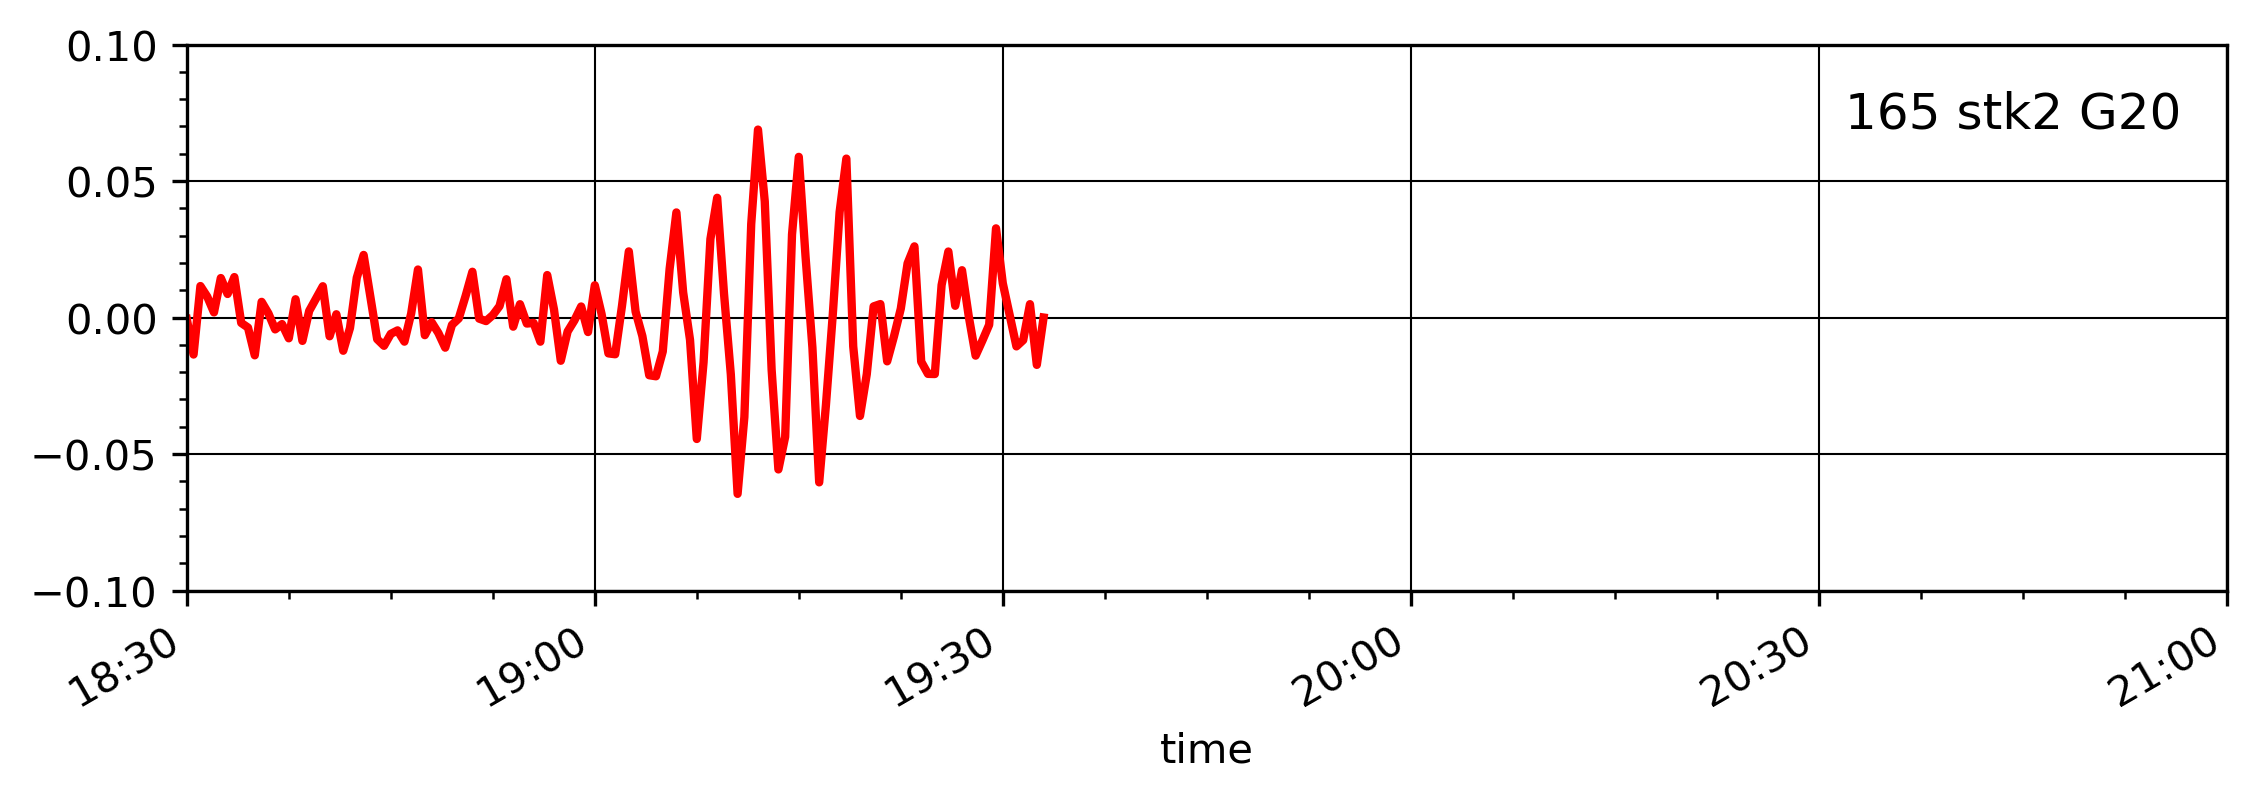

In [13]:
plot_waveform(fc.selected)

In [11]:
# params = get_params_datafile(fc.selected)

In [12]:
# params

In [13]:
# day = get_date_by_number(year=2009, day_number=164)
# dnum = get_day_number(year=2009, month=6, day=14)